## Using Qiskit Nature and VQE for finding the excited energy state of H2

> For additional information on these examples and Qiskit Nature please first check the `qiskit_nature_ground_state_vqe.ipynb` example.

Calculating the excited energy states of H2 will follow the exact same steps as calculating the ground state energy. The only difference is that we will use the QEOM algorithm to calculate the excited states. <br>
The QEOM algorithm requires the ground state energy solver as input. In this example, we will use the VQE algorithm as the ground state energy solver just like the ground state VQE example. The QEOM algorithm will then calculate the excited states based on the ground state energy.

For more information on how to do the ground state energy calculation, please refer to the ground state energy calculation example.

The EOM method finds the excitation energies (differences in energy between the ground state and 
the excited states) by solving a pseudo-eigenvalue problem. Thus, the solver needs a `GroundStateEigensolver` to compute the ground state of the system. It then uses an estimator to estimate the energies of the different excited states. The `sd` string specifies the type of excitations to consider. In this case, `sd` stands for single and double excitations. The `EvaluationRule.ALL` specifies that all excited states should be calculated.

The QEOM algorithm will return a `QEOMResult` object that contains the total energies of the ground state and the excited states.

In [5]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator


driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

electronic_structure = driver.run()
mapper = JordanWignerMapper()
estimator = Estimator()

ansatz = UCCSD(
    electronic_structure.num_spatial_orbitals,
    electronic_structure.num_particles,
    mapper,
    initial_state=HartreeFock(
        electronic_structure.num_spatial_orbitals,
        electronic_structure.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(Estimator(), ansatz, SLSQP())
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

gse = GroundStateEigensolver(mapper, vqe_solver)
qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)

qeom_results = qeom_excited_states_solver.solve(electronic_structure)

print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030144
  - computed part:      -1.857275030144
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035695
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -1.244586766771
> Total excited state energy (Hartree): -0.524617772322
  2: 
* Electronic excited state energy (Hartree): -0.882724367172
> Total excited state energy (Hartree): -0.162755372723
  3: 
* Electronic excited state energy (Hartree): -0.224913469767
> Total excited state energy (Hartree): 0.495055524682
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 1.000 S^2: 2.000 M: -0.000
  2:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  3:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipol

## Plotting results

Doing this calculation for a range of `np.linspace(0.5, 2.8, 50)` (50 points between 0.5 and 2.8) and plotting the results will give us the energy curves of the ground state and three excited states for the H2 molecule.

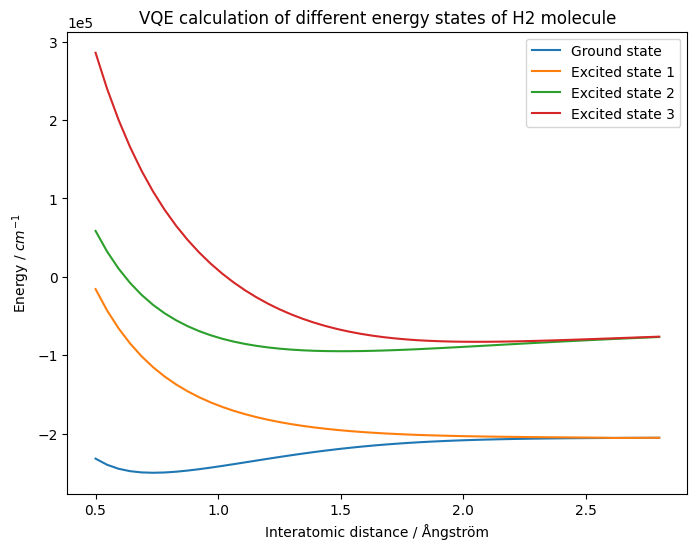

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import SLSQP


hartree_to_cm_inv = 2.194746313702e5
distances = np.linspace(0.5, 2.8, 50)

ground_state_energies = []
excited_state_energies1 = []
excited_state_energies2 = []
excited_state_energies3 = []

mapper = JordanWignerMapper()
estimator = Estimator()

for distance in distances:
    
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    electronic_structure = driver.run()

    ansatz = UCCSD(
        electronic_structure.num_spatial_orbitals,
        electronic_structure.num_particles,
        mapper,
        initial_state=HartreeFock(
            electronic_structure.num_spatial_orbitals,
            electronic_structure.num_particles,
            mapper,
        ),
    )
    
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    gse = GroundStateEigensolver(mapper, vqe_solver)
    excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)
    
    result = excited_states_solver.solve(electronic_structure)

    ground_state_energies.append(result.total_energies[0] * hartree_to_cm_inv) # Index 0 for the ground state
    excited_state_energies1.append(result.total_energies[1] * hartree_to_cm_inv) # Index 1 for the first excited state
    excited_state_energies2.append(result.total_energies[2] * hartree_to_cm_inv)
    excited_state_energies3.append(result.total_energies[3] * hartree_to_cm_inv)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(distances, ground_state_energies, label="Ground state")
plt.plot(distances, excited_state_energies1, label="Excited state 1")
plt.plot(distances, excited_state_energies2, label="Excited state 2")
plt.plot(distances, excited_state_energies3, label="Excited state 3")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('VQE calculation of different energy states of H2 molecule')
plt.xlabel("Interatomic distance / Ångström")
plt.ylabel("Energy / $cm^{-1}$")
plt.legend()
plt.show()

The minimum of the curves is the equilibrium bond distance of the H2 molecule at different excited states. We can find this by using the `argmin` function in from Numpy and finding the corresponding distance in the used distances linspace.


In [7]:
# Find the index of the lowest energy for each state
lowest_ground_state_energy_index = np.argmin(ground_state_energies)
lowest_excited_state_energy1_index = np.argmin(excited_state_energies1)
lowest_excited_state_energy2_index = np.argmin(excited_state_energies2)
lowest_excited_state_energy3_index = np.argmin(excited_state_energies3)

# Use the index to find the corresponding distance
lowest_ground_state_energy_distance = distances[lowest_ground_state_energy_index]
lowest_excited_state_energy1_distance = distances[lowest_excited_state_energy1_index]
lowest_excited_state_energy2_distance = distances[lowest_excited_state_energy2_index]
lowest_excited_state_energy3_distance = distances[lowest_excited_state_energy3_index]

print(f"Lowest ground state energy: {ground_state_energies[lowest_ground_state_energy_index]} Hartree at distance: {lowest_ground_state_energy_distance} Angstrom")
print(f"Lowest excited state 1 energy: {excited_state_energies1[lowest_excited_state_energy1_index]} Hartree at distance: {lowest_excited_state_energy1_distance} Angstrom")
print(f"Lowest excited state 2 energy: {excited_state_energies2[lowest_excited_state_energy2_index]} Hartree at distance: {lowest_excited_state_energy2_distance} Angstrom")
print(f"Lowest excited state 3 energy: {excited_state_energies3[lowest_excited_state_energy3_index]} Hartree at distance: {lowest_excited_state_energy3_distance} Angstrom")

Lowest ground state energy: -1.1373060261436525 Hartree at distance: 0.7346938775510203 Angstrom
Lowest excited state 1 energy: -0.935109354214535 Hartree at distance: 2.6122448979591835 Angstrom
Lowest excited state 2 energy: -0.4314279787142885 Hartree at distance: 1.4857142857142855 Angstrom
Lowest excited state 3 energy: -0.37684028667026254 Hartree at distance: 2.0489795918367344 Angstrom


## Using a classical optimizer to find the minimum state energies

If we put the VQE and QEOM calculations in a function, we can use a classical optimizer to find the minimum of the curve. In this example we use the golden section search from scipy to find the minimum between a range of 0.5 and 2.8. This might be less precise as the example on the ground state energy has a smaller range. The golden section search is a really efficient search algorithm as it only requires one new function evaluation per iteration. It is also robust and easy to use in the sense that is does not require any derivative information. However, it might not be the best choice for high-dimensional optimization problems.

In [8]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

from scipy.optimize import golden

mapper = JordanWignerMapper()
estimator = Estimator()


def vqe_excited_states_calculation(distance, energy_level=1):
    
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    electronic_structure = driver.run()

    ansatz = UCCSD(
        electronic_structure.num_spatial_orbitals,
        electronic_structure.num_particles,
        mapper,
        initial_state=HartreeFock(
            electronic_structure.num_spatial_orbitals,
            electronic_structure.num_particles,
            mapper,
        ),
    )
    
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    gse = GroundStateEigensolver(mapper, vqe_solver)
    excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)
    
    result = excited_states_solver.solve(electronic_structure)
    
    return result.total_energies[energy_level]

energy_levels = [0, 1, 2, 3]

# Use the golden section search from scipy to find the minimum for each energy level
for energy_level in energy_levels:
    result = golden(lambda x: vqe_excited_states_calculation(x, energy_level), brack=(0.5, 2.8))
    print(f"The minimal energy for level {energy_level} is at interatomic distance {result} \nCorresponding energy {vqe_excited_states_calculation(result, energy_level)}")

The minimal energy for level 0 is at interatomic distance -0.7348649533712799 
Corresponding energy -1.1373060511653026
The minimal energy for level 1 is at interatomic distance 2.611326097521542 
Corresponding energy -0.9351157268675666
The minimal energy for level 2 is at interatomic distance 12.0136105833071 
Corresponding energy -0.9331636986440043
The minimal energy for level 3 is at interatomic distance 10.07738419848855 
Corresponding energy -0.9331636980410591
